### Manhattan Plot

In [1]:
import os
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
os.chdir('/media/HDD_4TB_1/jordi/cfuses_gnn_enrollhd_2024/')

# Results directory
results_dir = "data/ml_results/regressors_info/"

# Data directory
data_dir = "data/features/"

In [3]:
lookup_tab = pd.read_csv("data/biomart/revised_filtered_snp_gene_lookup_tab.txt", sep='\t')

In [4]:
# Get maximum position for each chromosome
chrom_lengths = pd.read_csv("data/biomart/chrom_lengths_grch37.txt", sep='\t')

In [5]:
def manhattan_df(model_snps_df_name):
    '''Read table with SNPs related to model feature importance and
    classify them by chromosome relative position.'''
    
    # Get table with snps importance measures
    model_snps = pd.read_csv(results_dir+model_snps_df_name, sep='\t')
    
    # Initialize empty lists to store chrom and pos values
    chrom_values = []
    pos_values = []

    # Iterate over rows in dataframe
    for index, row in model_snps.iterrows():
        lookup_match = lookup_tab[lookup_tab['refsnp_id']==row['SNP']]
        
        # Extract chrom and pos values
        if not lookup_match.empty:
            chrom_value = lookup_match['chr_name'].values[0]
            pos_value = lookup_match['chrom_start'].values[0]
        else:
            # If no match is found, assign NaN values
            chrom_value = pd.NA
            pos_value = pd.NA
            
        # Append matches
        chrom_values.append(chrom_value)
        pos_values.append(pos_value)

    # Add chrom and pos columns to model_snps 
    model_snps['chrom'] = chrom_values
    model_snps['position'] = pos_values
    
    # Merge model_snps with chrom_lengths based on the chromosome name
    merged_df = pd.merge(model_snps, chrom_lengths, left_on='chrom', right_on='Chromosome')

    # Drop the 'Chromosome' column from the merged DataFrame
    merged_df = merged_df.drop(columns=['Chromosome'])

    # Calculate relative position of each SNP on its chromosome
    merged_df['relative_position'] = merged_df['position'] / merged_df['Total_length_bp']

    # Sort the merged_df DataFrame by chromosome and position
    merged_df_sorted = merged_df.sort_values(by=['chrom', 'position'])

    # Convert chrom number into an integer
    merged_df_sorted['chrom'] = merged_df_sorted['chrom'].apply(lambda x: int(x))
    # Ensure there is always minimum 1 row representing of each chromosome, 
    # if there is a missing chrom, add a 0 value row
    
    return merged_df_sorted

In [6]:
def manhattan(merged_df_sorted, model_type, model_name, thres = None, name_snps = False):
    '''
       
    model_type: 
    - 'lsq': least squares methods like lasso and elastic net, to use coefficient as importance measure
    - 'tree': tree-based methods, to use gain as importance measure
    
    Minimum importance measure thres used values:
    - lasso: 0.02
    - xgboost: 14
    '''
    
    if model_type == 'lsq':
        meas_importance = 'Coefficient'
    elif model_type == 'tree':
        meas_importance = 'Gain'
    else:
        print("Invalid model type. Should be either 'lsq' or 'tree'.")
    
    # Get the set of all chromosomes present in the DataFrame
    all_df_chroms = set(merged_df_sorted['chrom'])

    # Create a DataFrame with all possible chromosomes and initialize the counts to 0
    all_chroms = set([x for x in range(1,23)])

    # Find missing chromosomes
    missing_chroms = all_chroms ^ all_df_chroms
    # Add empty value row
    if len(missing_chroms) != None:
        for chrom in missing_chroms:
            total_chr_length = chrom_lengths[chrom_lengths['Chromosome'] == str(chrom)].iloc[0,1]
            dummy_row = pd.DataFrame({'SNP': ['dummy'], meas_importance:[0], 'Gene':['dummy'], 'GO':['dummy'], 
                                    'chrom':[chrom], 'position':[50], 
                                    'Total_length_bp': [total_chr_length], 
                                    'relative_position': [50/total_chr_length]})
            merged_df_sorted = pd.concat([merged_df_sorted, dummy_row], ignore_index=True)
    # Sort the merged_df DataFrame by chromosome number and position
    merged_df_sorted = merged_df_sorted.sort_values(by=['chrom', 'position'])
    merged_df_sorted
    # Initialize variables to keep track of the x-axis position
    x_position = 0
    prev_chromosome = None

    # Set global font sizes
    plt.rcParams.update({
        'axes.titlesize': 24,
        'axes.labelsize': 20,
        'xtick.labelsize': 16,
        'ytick.labelsize': 16,
        'legend.fontsize': 16,
        'figure.titlesize': 24
    })

    width_px = 1920
    height_px = 1080
    dpi = 100

    # Calculate the figure size in inches
    fig_width = width_px / dpi
    fig_height = height_px / dpi

    plt.figure(figsize=(fig_width, fig_height), dpi=dpi)

    # Number of colors needed
    num_colors = 22

    # Get the colors from the tab20 colormap
    colors = plt.cm.tab20.colors

    # Cycle through the colors to get the desired number of contrasting colors
    contrasting_colors = [colors[i % 20] for i in range(num_colors)]

    # Bar width
    bar_width = 0.05

    # Get SNPs names by order of appearance
    highersnps = []

    # Iterate over each coefficient
    for index, row in merged_df_sorted.iterrows():
        chromosome = row['chrom']
        relative_position = row['relative_position']
        importance = row[meas_importance]
        
        # Check if the chromosome has changed
        if prev_chromosome is not None and chromosome != prev_chromosome:
            x_position += 1  # Increment x-axis position for the next chromosome
        prev_chromosome = chromosome
        
        # Plot the SNP as a bar
        plt.bar(x_position + relative_position, importance, color=contrasting_colors[int(chromosome)-1], width=bar_width)
        
        if thres != None:
        
            # If the coefficient is higher than 0.15, label the bar
            # if coefficient > 0.02:
            #     plt.text(x_position + relative_position, coefficient, row['SNP'], ha='center', va='bottom')
            #     plt.text(x_position + relative_position, coefficient + 0.0025, row['Gene'], ha='center', va='bottom', fontsize=8, style='italic')
            # elif coefficient < -0.02:
            #     plt.text(x_position + relative_position, coefficient - 0.003, row['SNP'], ha='center', va='bottom')
            #     plt.text(x_position + relative_position, coefficient - 0.006, row['Gene'], ha='center', va='bottom', fontsize=8, style='italic')
            if abs(importance) > thres:
                highersnps.append([row['SNP'], row['Gene']])
                if name_snps == True:
                    plt.text(x_position + relative_position, importance, row['SNP'], ha='center', va='bottom')    
            
    # Set x-axis labels and ticks
    plt.xlabel('Chromosome')
    plt.xticks(range(len(merged_df_sorted['chrom'].unique())), merged_df_sorted['chrom'].unique())

    plt.ylabel(meas_importance + ' Value')
    plt.ylim([min(merged_df_sorted[meas_importance])*1.3, max(merged_df_sorted[meas_importance])*1.2])
    plt.grid(axis='y')

    if meas_importance == 'Coefficient':
        plt.title(model_name + "'s SNP coefficients over relative chromosome position")
    elif meas_importance == 'Gain':
        plt.title(model_name + "'s SNP gains over relative chromosome position")        
    plt.show()
    
    return highersnps

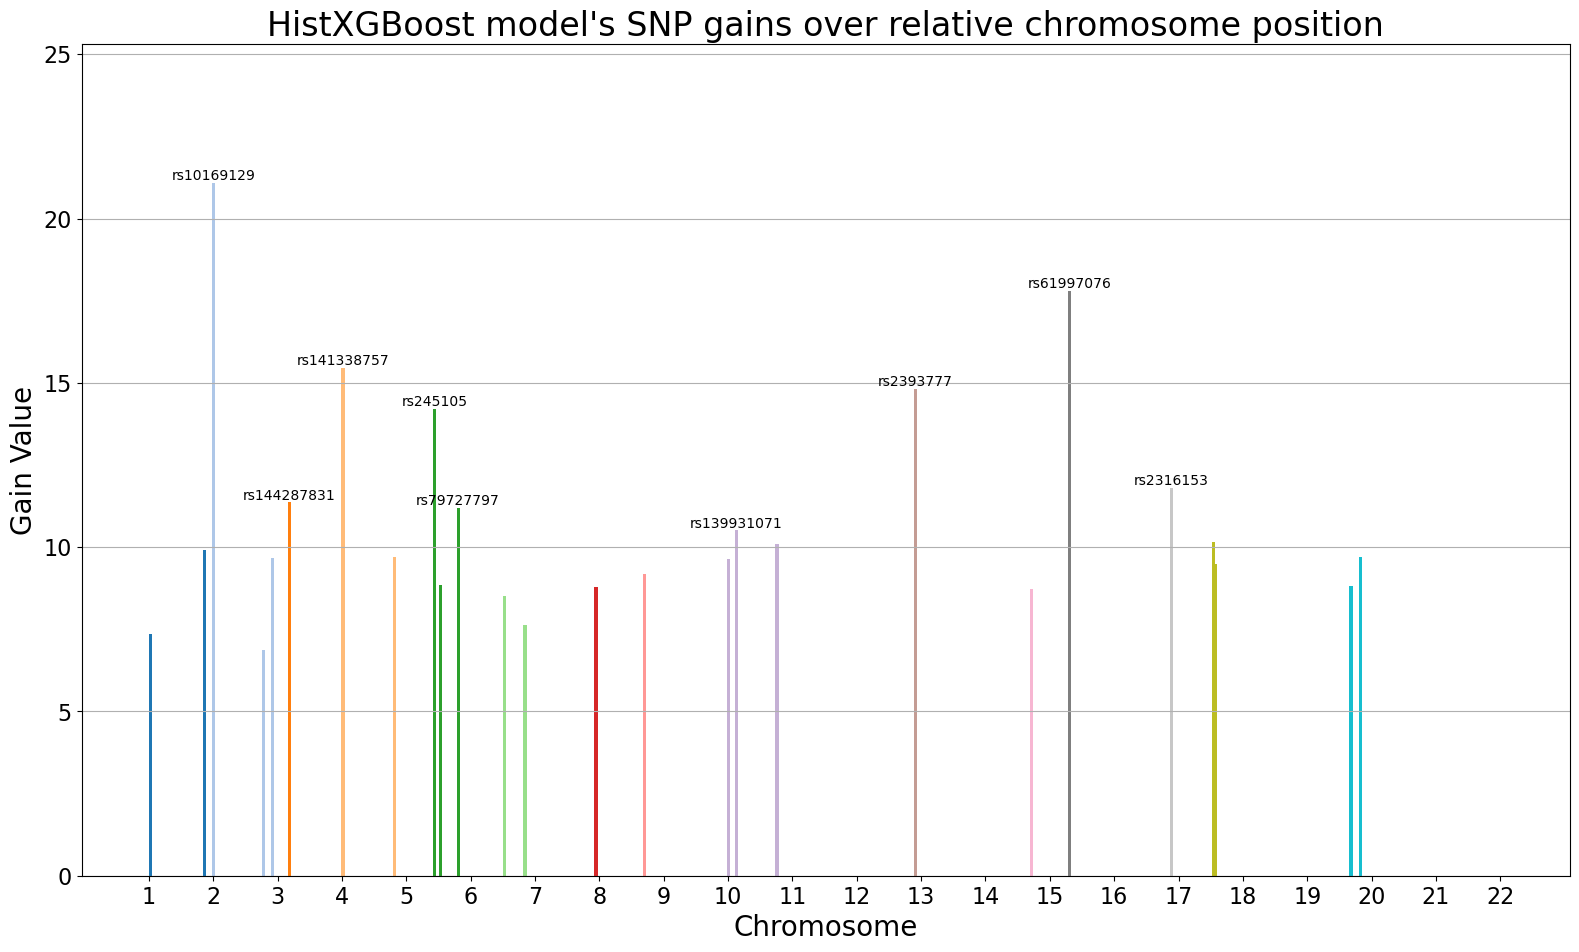

[['rs10169129', 'MYT1L'],
 ['rs144287831', 'MLH1'],
 ['rs141338757', 'HTT'],
 ['rs245105', 'DHFR'],
 ['rs79727797', 'TCERG1'],
 ['rs139931071', 'STAM'],
 ['rs2393777', 'HNF1A'],
 ['rs61997076', 'FAN1'],
 ['rs2316153', 'CDYL2']]

In [13]:
merged_df_sorted = manhattan_df('histXGBoost_regressor_bsc_coefs.txt')
manhattan(merged_df_sorted, model_type = 'tree', model_name = 'HistXGBoost model', thres = 10.5, name_snps = True)

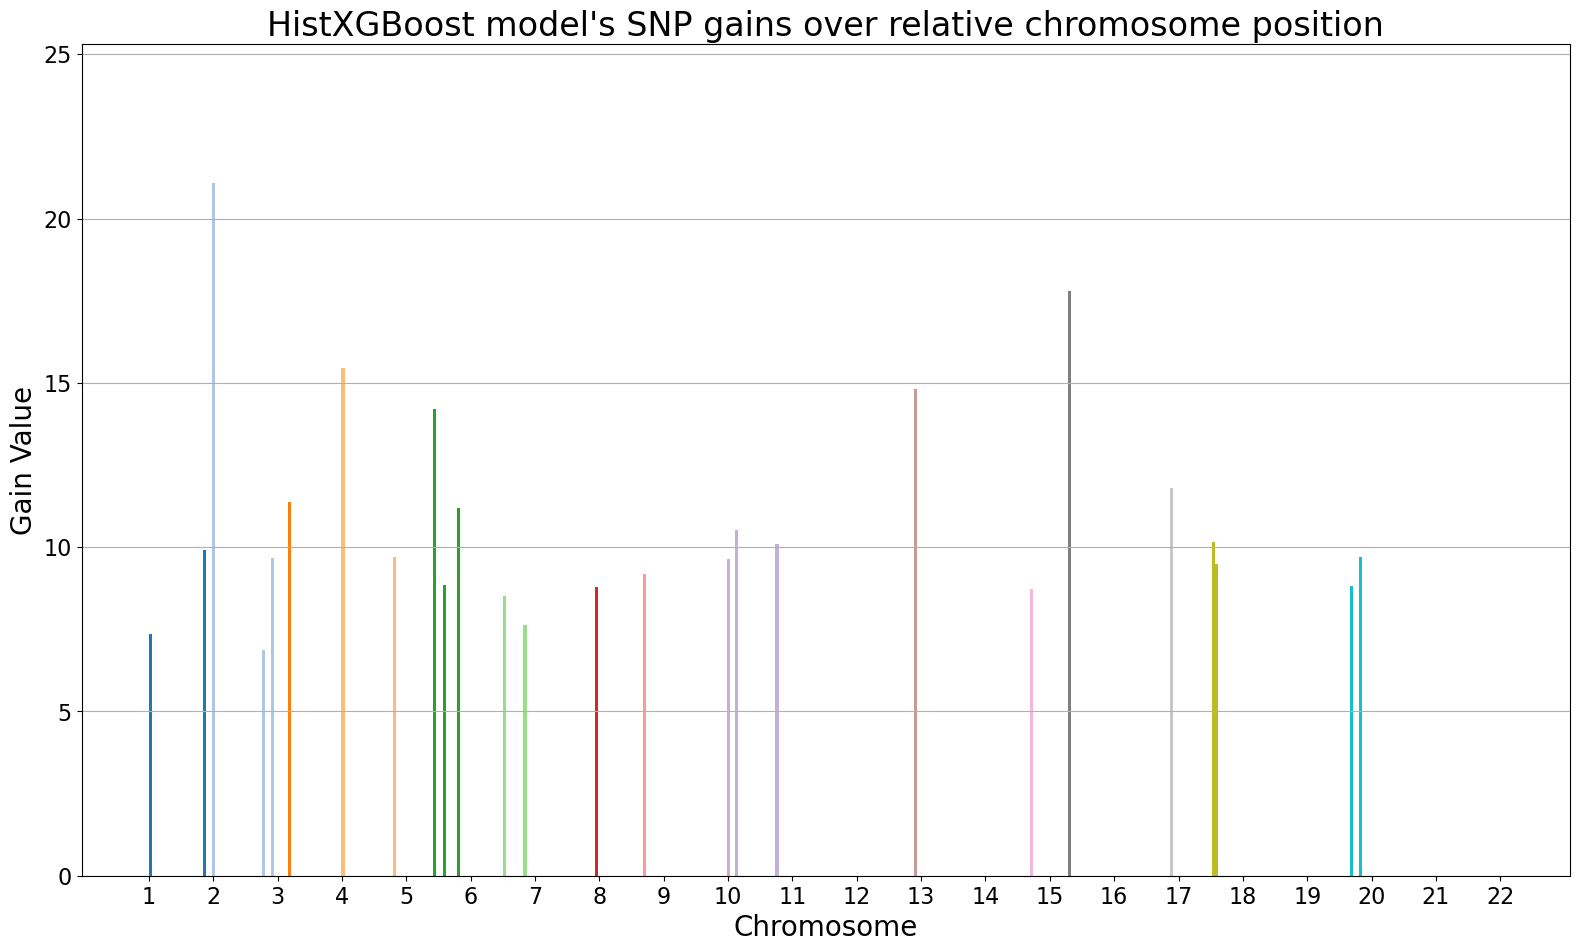

[]

In [11]:
manhattan(merged_df_sorted, model_type = 'tree', model_name = 'HistXGBoost model')